In [1]:
%run imports.py

##### Mask size vs Dice Score Comparison using butterfly plot

In [2]:
def get_mask_area_ratio(mask):
    foreground = (mask == 1).sum().item() 
    total_pixels = mask.numel() 
    return foreground / total_pixels

def get_test_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    test_data = ConcatDataset(test_subsets)
    
    test_dataset = KvasirDataset(data=test_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return test_dataset

def get_train_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] not in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    train_data = ConcatDataset(test_subsets)
    
    train_dataset = KvasirDataset(data=train_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return train_dataset

In [3]:
train_dataset = get_train_dataset(subsets_path=f"../data/subsets")
test_dataset = get_test_dataset(subsets_path=f"../data/subsets")
full_dataset = ConcatDataset([train_dataset, test_dataset])

### Best model butterfly plot

In [6]:
def get_best_model_area_vs_dice(data, model_name, model_config, ckpt_path, device):
    model = select_model(model_name=model_name, model_config=model_config)
    
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    area_vs_score_list = []

    for i in range(len(data)):
        image, mask = data[i][0].to(device), data[i][1].to(device)
        area_ratio = get_mask_area_ratio(mask)

        with torch.no_grad():
            preds = model(image.unsqueeze(0)).squeeze(0)
            dice_score = calculate_dice_score(preds=preds, targets=mask, device=device, model_name=model_name)

        area_vs_score_list.append((area_ratio, dice_score.item()))

    return area_vs_score_list


def plot_best_model_butterfly_mask_vs_score(n_bins, threshold, results):
    mask_bins = np.linspace(0.0, 1.0, n_bins + 1)
    data_bins = [[] for _ in range(n_bins)]

    for area, score in results:
        for j in range(n_bins):
            if mask_bins[j] <= area < mask_bins[j + 1]:
                data_bins[j].append(score)
                break

    butterfly_data = [
        (
            sum(score < threshold for score in bin_scores),  # below
            sum(score > threshold for score in bin_scores)   # above
        )
        for bin_scores in data_bins
    ]

    below_counts = [x[0] for x in butterfly_data]
    above_counts = [x[1] for x in butterfly_data]

    bar_width = 0.35
    index = np.arange(n_bins)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(index, -np.array(below_counts), bar_width, color='blue', label='Below Threshold')
    ax.bar(index, above_counts, bar_width, color='red', label='Above Threshold')

    ax.axhline(y=0, color='black', linestyle='--')

    for i in range(n_bins):
        ax.text(i, -below_counts[i] - 0.5, str(below_counts[i]), ha='center', va='top', fontsize=9)
        ax.text(i, above_counts[i] + 0.5, str(above_counts[i]), ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Mask Area Ratio Bins')
    ax.set_ylabel('Dice Score Counts')
    ax.set_xticks(index)
    ax.set_xticklabels([f'{mask_bins[i]:.2f}-{mask_bins[i+1]:.2f}' for i in range(n_bins)])
    ax.legend()
    ax.set_title(f"Dice Score Distribution Across Mask Size Bins (Threshold = {threshold})")

    plt.tight_layout()
    plt.show()


In [10]:
ckpt_path = "/mnt/c/Users/dewan/Desktop/train_oversample/models/post_oversample.iter4.segformer_b2.size_384x96.pt"

area_vs_score_results = get_best_model_area_vs_dice(data=test_dataset, 
                                                    model_name=env_vars["model_name"], 
                                                    model_config=env_vars["model_config"], 
                                                    ckpt_path=ckpt_path, 
                                                    device="cuda")


/tmp/ipykernel_12844/2332223702.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


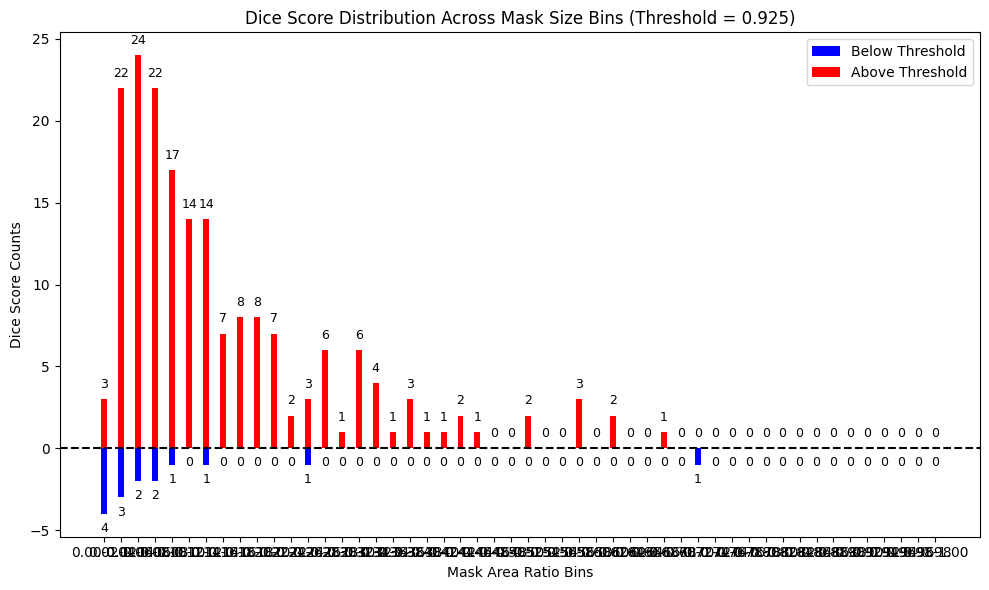

In [33]:
plot_best_model_butterfly_mask_vs_score(n_bins=50, 
                                        threshold=0.925, 
                                        results=area_vs_score_results)

In [ ]:
def get_sas_modelwise_area_vs_dice(data, model_dir, model_name, model_config, device, savepath):
    model = select_model(model_name=model_name, model_config=model_config)
    model_files = sorted(os.listdir(model_dir))
    
    results = {}
    for fname in model_files:
        fname_parts = fname.split(".")
        sas_status = fname_parts[0]
        split_key = fname_parts[-2].split("%")[0]
        
        if split_key not in results:
            results[split_key] = {"presas": {}, 
                                  "postsas" : {}}
        
        sas_model = copy.deepcopy(model)
        checkpoint = torch.load(f"{model_dir}/{fname}", weights_only=True)
        sas_model.load_state_dict(checkpoint['model_state_dict'])
        
        sas_model.to(device)
        
        
        area_vs_score_list = []
        sas_model.eval()
        
        for idx in range(len(data)):
            image, mask = data[idx][0].to(device), data[idx][1].to(device)
            
            area_ratio = get_mask_area_ratio(mask)
            
            batched_image = image.unsqueeze(0).to(device)
            preds = sas_model(batched_image)
            preds = preds.squeeze(0)
            dice_score = calculate_dice_score(preds=preds, 
                                              targets=mask, 
                                              device=device, 
                                              model_name=model_name)
            
            tuple_data = (area_ratio, dice_score.item())
            area_vs_score_list.append(tuple_data)
            
        
        if sas_status=="presas":
            results[split_key]["presas"]["area_vs_score"] = area_vs_score_list
        else:
            results[split_key]["postsas"]["area_vs_score"] = area_vs_score_list
            
            
    with open(f"{savepath}/area_vs_score_results.json", "w") as file:
        json.dump(results, file, indent=4)
    
    return results

In [ ]:
try:
    with open(f"{env_vars['output_folder_path']}/area_vs_score_results.json", "r") as file:
        results = json.load(file)
except Exception as e: 
    print(e)
    results = get_sas_modelwise_area_vs_dice(data=full_dataset, 
                                             model_dir=f"{env_vars['results_root']}/final-results-with-segformer/train_semi_auto/models", 
                                             model_name=f"{env_vars['model_name']}", 
                                             model_config=f"{env_vars['model_config']}", 
                                             device="cuda", 
                                             savepath=f"{env_vars['output_folder_path']}")
    

In [ ]:
splits = list(results.keys())
stages = ["presas", "postsas"]
key = "area_vs_score"

# json doesn't save tuples so converting back to tuples
for split in splits:
    for stage in stages:
        for idx in range(len(results[split][stage][key])):
            results[split][stage][key][idx] = tuple(results[split][stage][key][idx])

In [ ]:
def plot_butterfly_mask_vs_score(ax, n_bins, threshold, results, split_key, stage_key, key="area_vs_score"):
    data = results[split_key][stage_key][key]

    mask_bins = np.linspace(0.0, 1.0, n_bins+1)
    data_bins = [[] for _ in range(len(mask_bins)-1)]
    butterfly_data = []

    for idx in range(len(data)):
        area, score = data[idx][0], data[idx][1]
        
        for j in range(len(mask_bins)-1):
            if mask_bins[j] <= area < mask_bins[j+1]:
                data_bins[j].append(score)
                break
            
    for j in range(len(data_bins)):
        above_count = sum(1 for value in data_bins[j] if value > threshold)
        below_count = sum(1 for value in data_bins[j] if value < threshold)
        
        butterfly_data.append((below_count, above_count))

    below_counts = [x[0] for x in butterfly_data]
    above_counts = [x[1] for x in butterfly_data]
    
    bar_width = 0.35
    index = np.arange(n_bins)

    ax.bar(index, -np.array(below_counts), bar_width, color='blue', label='Below Threshold')
    ax.bar(index, np.array(above_counts), bar_width, color='red', label='Above Threshold')

    ax.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
    
    for i in range(n_bins):
        ax.text(i, -below_counts[i] - 0.5, str(below_counts[i]), ha='center', va='top', fontsize=9)
        ax.text(i, above_counts[i] + 0.5, str(above_counts[i]), ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Mask Sizes')
    ax.set_ylabel('Counts')
    split_pct = int(split_key.split("_")[-1])
    # ax.set_title(f'{split_pct}%:{80-split_pct}% ({stage_key})')
    
    ax.set_xticks(index)
    ax.set_xticklabels([f'{mask_bins[i]:.2f}-{mask_bins[i+1]:.2f}' for i in range(n_bins)])
    ax.legend()

In [ ]:
# fig, axes = plt.subplots(len(splits), len(stages), figsize=(20, 30))

# for i, split_key in enumerate(splits):
#     for j, stage_key in enumerate(stages):
#         plot_butterfly_mask_vs_score(axes[i, j], n_bins=10, 
#                                      threshold=0.5,
#                                      results=results, 
#                                      split_key=split_key, 
#                                      stage_key=stage_key, 
#                                      key="area_vs_score")

# plt.tight_layout()
# plt.savefig('../outputs/figures/area_vs_score_butterfly_plot.pdf', dpi=300)
# plt.close()


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))

# for j, stage_key in enumerate(stages):
plot_butterfly_mask_vs_score(axes, 
                                n_bins=50, 
                                threshold=0.5,
                                results=results, 
                                split_key=splits[0],
                                stage_key=stage_key, 
                                key="area_vs_score")

plt.tight_layout()
plt.savefig(f'../outputs/figures/area_vs_score_butterfly_plot_{splits[0]}.pdf', dpi=300)
plt.close()


#### Train vs Test dataset distribution balancing

In [ ]:
def analyze_train_vs_test_dist(train_dataset, test_dataset, savefig_name):
    
    training_mask_area_ratios = [get_mask_area_ratio(train_dataset[idx][1]) for idx in range(len(train_dataset))]
    testing_mask_area_ratios = [get_mask_area_ratio(test_dataset[idx][1]) for idx in range(len(test_dataset))]
    
    x_vals = np.linspace(0, 1, 1000)
    train_kde = gaussian_kde(training_mask_area_ratios, bw_method=0.5)
    test_kde = gaussian_kde(testing_mask_area_ratios, bw_method=0.5)
    
    train_y_vals,test_y_vals = train_kde(x_vals), test_kde(x_vals)
    ks_stat, p_value = ks_2samp(training_mask_area_ratios, testing_mask_area_ratios)
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(x_vals, train_y_vals, color="blue", alpha=0.3)
    ax.plot(x_vals, train_y_vals, color="blue", linewidth=2, label="KDE on training data ")
    ax.fill_between(x_vals, test_y_vals, color="red", alpha=0.3)
    ax.plot(x_vals, test_y_vals, color="red", linewidth=2, label="KDE on testing data")

    ax.set_title(f"KDE for training and testing dataset mask distribution (KS Stat: {ks_stat:.4f}, P-value: {p_value:.4f})")
    ax.set_xlabel("Mask Area Ratios")
    ax.set_ylabel("Density")
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))
    
    plt.legend()
    plt.savefig(f'.{env_vars["output_folder_path"]}/figures/{savefig_name}.pdf', format="pdf", bbox_inches="tight")
    
    plt.close()

In [ ]:
analyze_train_vs_test_dist(train_dataset, 
                           test_dataset,
                           savefig_name="train_vs_test_kde_original")